In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import lqr, dare
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.environment import Cavity_Particle

In [2]:
T = 293
rho = 2200
index_refraction = 1.4440
p = 0
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
tweezer_waist = 0.6e-6
eta_detection = 1
delta_t = 1e-9
control_step = 30 # defined as int, number of time steps of simulation necessary to compute the control policy
fs = 1/(control_step*delta_t)

cavity_waist = 100e-6
cavity_length = 50e-3
eta_detec = 0.178
coupling = 6.68e-42

detuning_ratio = 1 #defined with respect to the particle's frequency
cavity_linewidth_ratio = 1

gamma, omega, ba_force, std_detection, std_z, g_cs, detuning, cavity_linewidth =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection,\
                                     cavity_length, cavity_waist, detuning_ratio, cavity_linewidth_ratio,\
                                     T = T, rho = rho, index_refraction = index_refraction)

In [3]:
print(g_cs)

g_cs = 0

period = 2 * np.pi / omega
delta_t = 1e-9
control_step = 30 # defined as int, number of time steps of simulation necessary to compute the control policy
t = np.arange(0, 20 * period, delta_t)
N = t.shape[0]

1.3065307438961458e-09


In [27]:
env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    g_cs,
    coupling,
    radius=R,
    rho=rho,
    eta_detection=eta_detec,
    T=T
)

In [28]:
pulse_amplitude = 0
pulse_center = 2500
pulse_width = 200
alpha_in = []
for i in range(t.shape[0]):
    # alpha = i*(t.shape[0]-i)*pulse_amplitude
    alpha = pulse_amplitude * (
        np.exp(-((i - pulse_center) ** 2) / (2 * pulse_width**2))
    )
    # +np.exp(-(i-(pulse_center+t.shape[0]/2))**2/(2*pulse_width**2)))
    alpha_in.append(alpha)

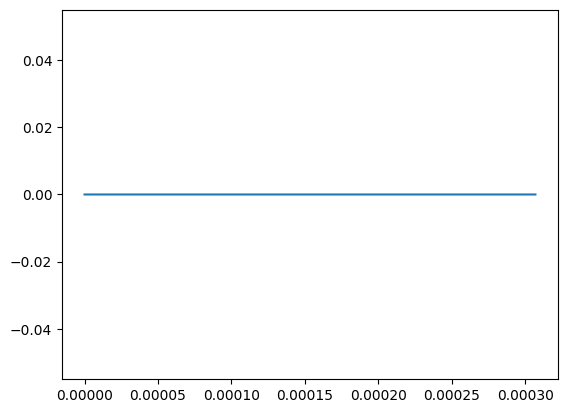

In [29]:
plt.plot(t, alpha_in)
plt.show()

In [30]:
variance_process = env.thermal_force_std**2 + env.backaction_std**2
std_detection = np.sqrt(5.4e-21)/(env.zp_x)
std_detection, variance_process

(35.02814170059426, 150286.73477987695)

In [31]:
Q = np.array(
    [
        [(env.__optical_noise__**2)*cavity_linewidth, 0, 0, 0],
        [0, (env.__optical_noise__**2)*cavity_linewidth, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process],
    ]
)
R = np.array([[np.power(std_detection, 2)]])

In [32]:
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
cost_states = np.array([[1e-5, 0, 0, 0],
                        [0, 1e-5, 0, 0],
                        [0, 0, omega/2, 0],
                        [0, 0, 0, omega/2]
                       ])
(G, S, E) = lqr(Ad, env.B*delta_t*control_step, cost_states, 2000*omega)

x0 = 10
P0 = 1*np.matrix(np.eye(4))
estimation = np.matrix([[0], [0], [x0], [0]])
states = np.array([[0], [0], [x0], [0.0]])
G, omega, Ad, env.B*delta_t*control_step

(array([[ 4.16489638e-05, -2.36521862e-04,  5.15150359e+06,
          4.09138683e+05]]),
 409282.306543384,
 array([[ 0.99380465,  0.01220301,  0.        ,  0.        ],
        [-0.01220301,  0.99380465,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.99992462,  0.01227816],
        [ 0.        ,  0.        , -0.01227816,  0.99992462]]),
 array([[0.e+00],
        [0.e+00],
        [0.e+00],
        [3.e-08]]))

In [33]:
new_states = np.zeros((N, 4))
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 4))
estimated_states[0, :] = estimation.reshape((4))
estimation = estimation.reshape((4, 1))
control = np.array([[0]])
estimate_Vx = []
estimate_Vp = []
controls = []
kalman = KalmanFilter(estimation, P0, Ad, env.B * delta_t * control_step, env.C, Q * delta_t * control_step, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measured_states[i] = states[2, 0] + std_detection * np.random.normal()
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i])
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((4))
        estimation = estimated_states[i, :].reshape((4, 1))
        estimate_Vx.append(np.array(kalman.error_covariance_aposteriori[-1][2, 2]))
        estimate_Vp.append(np.array(kalman.error_covariance_aposteriori[-1][3, 3]))
        control = -0.5*np.matmul(G, estimation)
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]
        estimate_Vx.append(estimate_Vx[-1])
        estimate_Vp.append(estimate_Vp[-1])

    controls.append(float(control))
    states = env.step(states, alpha_in=alpha_in[i], control=control, delta_t=delta_t)

  0%|                                                                                                                                                                                                                             | 0/307035 [00:00<?, ?it/s]/tmp/ipykernel_9141/3955042800.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  new_states[i, :] = states[:, 0]
/tmp/ipykernel_9141/3955042800.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  measured_states[i] = states[2, 0] + std_detection * np.random.normal()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307035/307035 [00:26<00:00, 11742.90it/s]


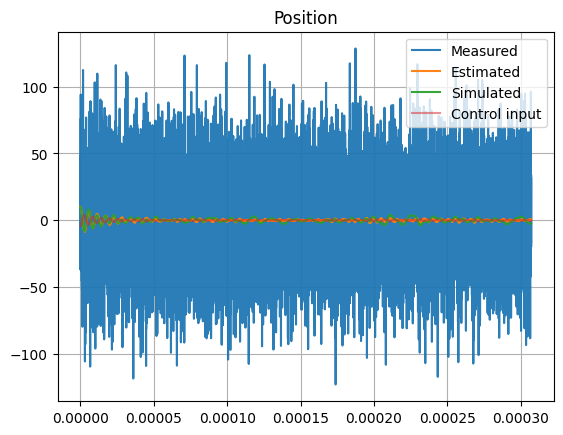

In [34]:
plt.close("all")
fig1 = plt.Figure()
plt.title("Position")
plt.plot(t[1:], measured_states[1:], alpha = 0.95)
plt.plot(t[1:], estimated_states[1:, 2], alpha = 0.95)
plt.plot(t[1:], new_states[1:, 2],alpha = 0.95)
C = max(controls)/4
controls = [x/C for x in controls]
plt.plot(t[1:], controls[1:], alpha = 0.5)
plt.grid()
plt.legend(["Measured", "Estimated", "Simulated", "Control input"])
plt.show()

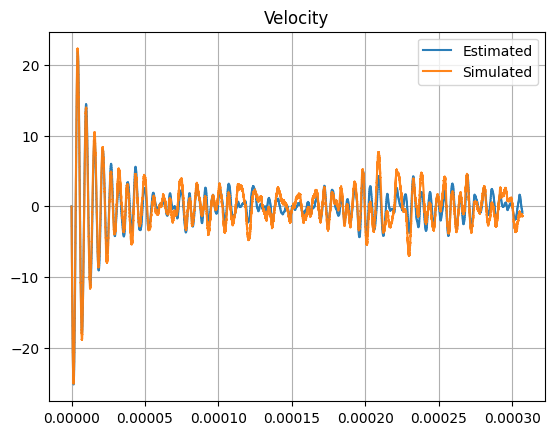

In [35]:
plt.close("all")
fig1 = plt.Figure()
plt.title("Velocity")
plt.plot(t[1:], estimated_states[1:, 3], alpha = 0.95)
plt.plot(t[1:], new_states[1:, 3],alpha = 0.95)
plt.grid()
plt.legend(["Estimated", "Simulated"])
plt.show()

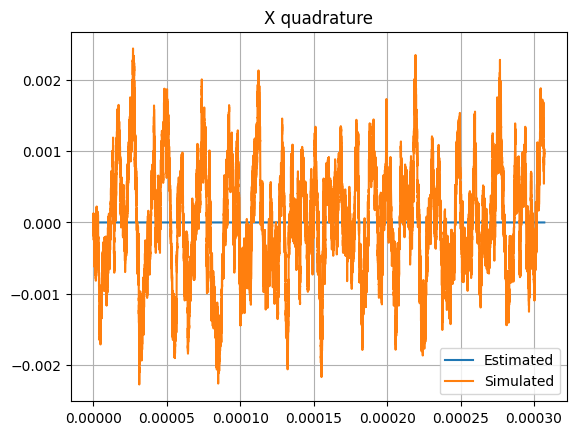

In [36]:
plt.figure()
#fig2 = plt.Figure()
plt.title('X quadrature')
plt.plot(t[1:], estimated_states[1:,0])
plt.plot(t[1:], new_states[1:,0])
plt.grid()
plt.legend(['Estimated','Simulated'])
plt.show()

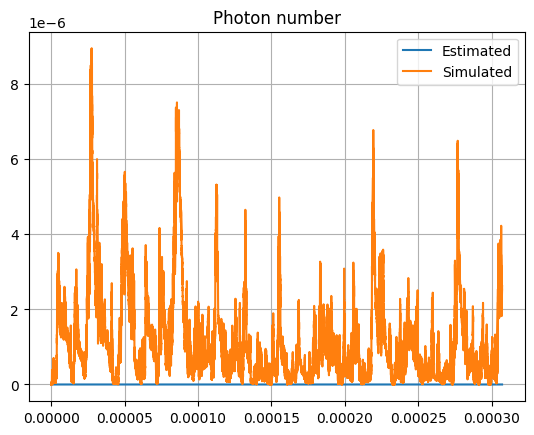

In [37]:

# In[63]:
fig2 = plt.Figure()
plt.figure()
plt.title("Photon number")
plt.plot(
    t[1:], np.power(estimated_states[1:, 0], 2) + np.power(estimated_states[1:, 1], 2)
)
plt.plot(t[1:], np.power(new_states[1:, 0], 2) + np.power(new_states[1:, 1], 2))
plt.grid()
plt.legend(["Estimated", "Simulated"])
plt.show()


In [38]:
kalman.error_covariance_apriori[-1]

matrix([[1.00615180e-06, 1.39631129e-21, 0.00000000e+00, 0.00000000e+00],
        [1.55274704e-21, 1.00615180e-06, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.34715596e+00, 1.82657898e-01],
        [0.00000000e+00, 0.00000000e+00, 1.82657898e-01, 2.37558518e+00]])